In [2]:
#Before training model, test it
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train/cardgame/pic_001.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cardgame', save_format='jpeg'):
    i += 1
    if i > 20:
        break 

In [9]:
from keras.optimizers import RMSprop

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50
125/125 [==============================] - 184s 1s/step - loss: 0.7621 - acc: 0.5610 - val_loss: 0.6622 - val_acc: 0.6725
Epoch 2/50
125/125 [==============================] - 147s 1s/step - loss: 0.6582 - acc: 0.6400 - val_loss: 0.6528 - val_acc: 0.7063
Epoch 3/50
125/125 [==============================] - 130s 1s/step - loss: 0.6256 - acc: 0.6925 - val_loss: 0.6141 - val_acc: 0.7037
Epoch 4/50
125/125 [==============================] - 128s 1s/step - loss: 0.5926 - acc: 0.7040 - val_loss: 0.6140 - val_acc: 0.6800
Epoch 5/50
125/125 [==============================] - 134s 1s/step - loss: 0.5917 - acc: 0.7165 - val_loss: 0.6056 - val_acc: 0.7225
Epoch 6/50
125/125 [==============================] - 122s 979ms/step - loss: 0.5784 - acc: 0.7320 - val_loss: 0.6122 - val_acc: 0.6937
Epoch 7/50
125/125 [==============================] - 120s 958ms/step - loss: 0.5656 - acc: 0.7310 - val_loss: 0.619

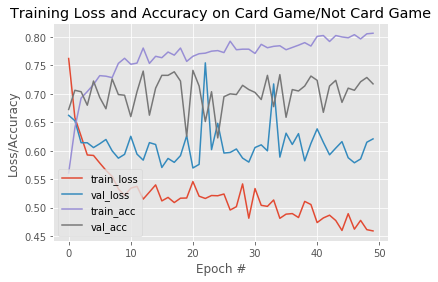

In [2]:
'''
In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created cardgame/ and not_cardgame/ subfolders inside train/ and validation/
- put the cat pictures index 0-999 in data/train/cardgame
- put the cat pictures index 1000-1400 in data/validation/cardgame
- put the not_cardgame pictures index 12500-13499 in data/train/not_cardgame
- put the dog pictures index 13500-13900 in data/validation/not_cardgame
So that we have 1000 training examples for each class, and 400 validation examples for each class.
In summary, this is our directory structure:
```
data/
    train/
        not_cardgame/
            image_001.jpg
            image_002.jpg
            ...
        cardgame/
            image_001.jpg
            image_002.jpg
            ...
    validation/
        not_cardgame/
            image_001.jpg
            image_002.jpg
            ...
        cardgame/
            image_001.jpg
            image_002.jpg
            ...
```
'''
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np


# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              #optimizer=optimizer,
              #optimizer='adam',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

H = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

modelName = "CardGame.model"
model.save(modelName)
model.save_weights('first_try.h5')

group1 = "Card Game"
group2 = "Not Card Game"

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on " + group1 + "/" + group2)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
#tutorial: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

#Code for training a model
#https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d

#Code for fine-tuning a model (didn't use it)
#https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975